# Settle Take Home #
Author: Evan Ball
Date:  2023-04-14

## Goal ##
* Determine key patterns associated with businesses that are likely to churn (vs not)
* Based on this, identify non-churned businesses that may be at risk of churn

## Approach ##
Using the sample data provided, we will train a logistic regression model and attempt to assign a probability of churn to each merchant. If this model has good predictive power, then we can use it to both evaluate which features are most predictive of future churn, and to assign a probability of churn to currently non-churned merchants, which will help us to identify at-risk merchants.

## Feature Definitions ##
The dependent variable will be a binary column called ‘HAS_CHURNED’, which will be 1 if the merchant churned, and 0 if not. The table below summarizes the independent variables used to train the model.

| Name  | Definition  |
|---|---|
| HAS_CREDIT_LIMIT  | Binary flag. 1 if the merchant currently has a credit limit, 0 if not.  |
| HAS_PAYMENT  | Binary flag. 1 if the merchant ever made a payment through Settle, 0 if not.   |
| LAST_30_PAYMENT_DELTA  | Percent change in payment count from the 30 days prior to churn, compared to the preceding 30 day period. For merchants without a churn date, the most recent date in the dataset is used (2023-04-12)   |
| DAYS_SINCE_LAST_PAYMENT | The number of days elapsed since the merchant’s most recent payment. For churned merchants, this is calculated from the date of churn. For non-churned merchants, 2023-04-12 is used.   |
| HAS_EVENT | Binary flag. 1 if the merchant has ever logged an event in fct_segment_events. 0 if not.  |
| DAYS_SINCE_LAST_EVENT  | The number of days elapsed since the merchant’s most recent event in fct_segment_events. For churned merchants, this is calculated from the date of churn. For non-churned merchants, 2023-04-12 is used.  |
| LAST_30_EVENT_DELTA  | Percent change in event count from the 30 days prior to churn, compared to the preceding 30 day period. For merchants without a churn date, the most recent date in the dataset is used (2023-04-12)  |

# Assemble the tools #

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Training #

In [94]:
data = pd.read_csv('data/settle_churn_training_data.csv')
data.head()

,BUSINESS_ID,HAS_CHURNED,HAS_CREDIT_LIMIT,HAS_PAYMENT,LAST_30_PAYMENT_COUNT,LAST_30_PAYMENT_DELTA,DAYS_SINCE_LAST_PAYMENT,HAS_EVENT,DAYS_SINCE_LAST_EVENT,LAST_30_EVENT_COUNT,LAST_30_EVENT_DELTA
0,1325,0,0,1,0,-100.000000,40,1,1,545,-44.045175
1,557,0,1,1,29,70.588235,2,1,1,1921,40.939105
2,1781,0,1,1,164,10.067114,1,1,1,3989,94.585366
3,9492,0,1,1,60,57.894737,1,1,1,1558,67.526882
4,1754,0,1,1,19,-9.523810,6,1,2,1662,71.163749


In [87]:
# Define features/target variable, and split out test and training data

feature_cols = ['HAS_CREDIT_LIMIT', 'HAS_PAYMENT', 'LAST_30_PAYMENT_DELTA', 'DAYS_SINCE_LAST_PAYMENT', 'HAS_EVENT', 'DAYS_SINCE_LAST_EVENT', 'LAST_30_EVENT_DELTA']

X = data[feature_cols]
y = data['HAS_CHURNED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

In [88]:
# fit the model and make predictions

logreg = LogisticRegression(random_state=16)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Model Evaluation #

In [89]:
# Build the confusion matrix, i.e, how many test cases did the model correctly predict (the values along the diagonal). The bottom left value is the count of cases where the model predicted a churn, but no churn occurred, and vice versa for the top right value

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[22,  2],
       [ 1, 18]], dtype=int64)

In [90]:
target_names = ['has churned', 'has not churned']
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

    has churned       0.96      0.92      0.94        24
has not churned       0.90      0.95      0.92        19

       accuracy                           0.93        43
      macro avg       0.93      0.93      0.93        43
   weighted avg       0.93      0.93      0.93        43



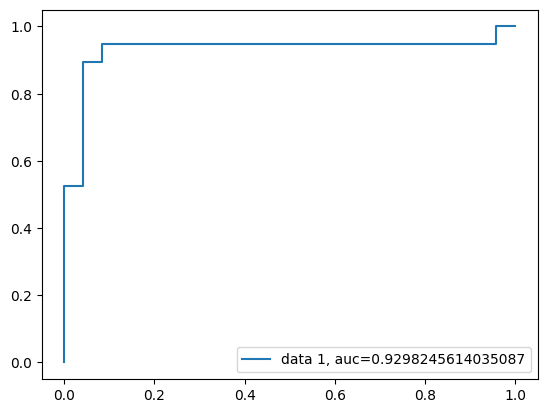

In [91]:
# Plot the ROC curve, and calculate AUC. A perfect predictor will have an AUC of 1, while a worthless predictor will have an AUC of 0.5.

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Our model has an AUC of .93, indicating strong predictive power. In addition, we have precision and recall numbers all over 90%, which indicates that when the model does predict churn, it is very accurate, AND that it is able to identify most churned merchants. Looking good!

# Find the most impactful variables #


In [92]:
# find the most predictive features and sort in descending order

variable_importance = permutation_importance(logreg, X_test, y_test)
imp = variable_importance['importances_mean']
coefs = logreg.coef_[0]

coef_importance = pd.DataFrame({'feature': feature_cols, 'importance': imp, 'coef_value': coefs})
coef_importance.sort_values(by=['importance'], ascending=False)

,feature,importance,coef_value
3,DAYS_SINCE_LAST_PAYMENT,0.209302,0.069445
5,DAYS_SINCE_LAST_EVENT,0.088372,0.072856
0,HAS_CREDIT_LIMIT,0.051163,-1.197839
2,LAST_30_PAYMENT_DELTA,0.009302,-0.012906
1,HAS_PAYMENT,0.000000,0.002011
4,HAS_EVENT,0.000000,-0.001968
6,LAST_30_EVENT_DELTA,0.000000,0.002366


# Identify at-risk Merchants #

In [93]:
# filter for only non-churned merchants

non_churned = data.loc[(data.HAS_CHURNED == 0)]
bus_ids = non_churned['BUSINESS_ID']
non_churned = non_churned[feature_cols]
churn_risk_scores = logreg.predict_proba(non_churned)[::,1]

non_churned['churn_probability'] = churn_risk_scores
non_churned['business_id'] = bus_ids
non_churned.sort_values(by=['churn_probability'], ascending=False)

,HAS_CREDIT_LIMIT,HAS_PAYMENT,LAST_30_PAYMENT_DELTA,DAYS_SINCE_LAST_PAYMENT,HAS_EVENT,DAYS_SINCE_LAST_EVENT,LAST_30_EVENT_DELTA,churn_probability,business_id
82,1,1,-100.000000,51,1,51,-100.000000,9.892703e-01,7952
122,1,1,-100.000000,83,1,9,-81.300813,9.765807e-01,7827
182,1,1,-100.000000,72,1,5,-52.360515,9.395529e-01,10121
208,1,1,-100.000000,54,1,13,-73.755656,8.834849e-01,12367
0,0,1,-100.000000,40,1,1,-44.045175,8.096085e-01,1325
...,...,...,...,...,...,...,...,...,...
120,1,1,377.777778,6,1,6,45.799012,4.521102e-04,7720
174,1,1,500.000000,2,1,2,761.904762,2.875547e-04,3368
95,1,1,1100.000000,8,1,6,407.142857,1.093395e-07,6282
69,1,1,2100.000000,14,1,7,1132.500000,2.462395e-12,6439


# Conclusions #

The most predictive features, unsurprisingly, relate to the recency of merchant engagement with Settle's products. In particular, payment activity seems to be much more predictive than anything else. Merchants who have made a payment very recently are much less likely to churn than those whom have not. Going in the other direction, merchants who have a credit limit in Settle's app are much **less** likely to churn than those who don't. This makes sense, as I assume merchants had to fill out a credit application to get a credit limit, which would indicate a higher level of engagement compared to those who didn't. Additionally, though I don't have access to this data, I assume many of the merchants with a credit limit actively use said credit, which would indicate an even higher level of engagement, and correspondingly lower likelihood to churn.

## Caveats ##

This dataset only contains 214 merchants, of which only 85 have churned. In reality, this isn't really enough data to draw strong conclusions from. In particular, it makes the model very vulnerable to over-fitting, with the risk that the model will not generalize well to new data.

## Further Investigation ##

I avoided performing any event-specific analysis using the data in **fct_segment_events**, instead opting to calculate a couple of aggregate metrics with that data to help train the model. The primary reason for this is that there are many more distinct events in that table than there are merchants to analyze, which would probably require me to arbitrarily decide which events to pay attention to, and which to not. If given access to full merchant data, I would certainly add event-specific features into the model in order to identify any features in particular that strongly predict churn (or lack thereof). Additionally, I used a logistic regression model here, because I am already familiar with that one, but it's possible that other methods such as Random Forests or other non-linear methods might fit the data better.